In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
from PIL import Image

In [2]:
# For streamlit display purposes
gender = st.sidebar.radio("Gender?: ", ('Female', 'Male'))

if gender == 'Female':
    df = pd.read_csv(r'wife.csv')
else:
    df = pd.read_csv(r'husband.csv')

2021-06-03 13:57:56.044 WARNING root: 
  command:

    streamlit run C:\Users\Wei Yi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [3]:
# Save feature names
feature_list = list(df.columns[:-1])

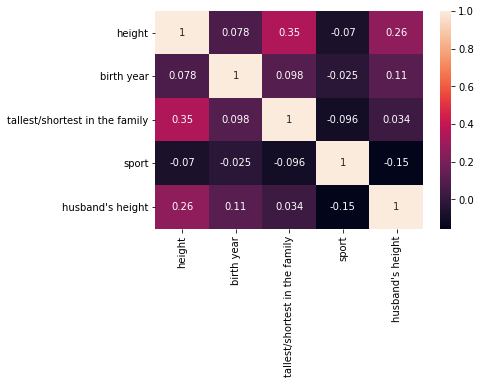

In [4]:
# Correlation matrix to check correlation coefficients between variables
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [5]:
# Separate data into X and y matrices
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
# Separate data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Standardize data in a range
sc = StandardScaler()
x1 = sc.fit_transform(X_train[:,:2])
x2 = sc.transform(X_test[:,:2])

# Normalize data in a range that has min and max value
mmc = MinMaxScaler()
x3 = mmc.fit_transform(X_train[:, 2:])
x4 = mmc.transform(X_test[:, 2:])

In [8]:
# Combine data that has been standardized and normalized
X_train = np.concatenate((x1, x3),axis=1)
X_test = np.concatenate((x2, x4),axis=1)

In [9]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rf = RandomForestRegressor(random_state=0) # default n_estimators=100

# Train the model on training data
rf_model = rf.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_predict = rf_model.predict(X_test)

In [10]:
# Calculate R2 score
from sklearn.metrics import r2_score
print('R2 Score = {}'.format(r2_score(y_test, y_predict)))

R2 Score = 0.2252026388891053


In [11]:
# Calculate mean squared error (MSE)
from sklearn.metrics import mean_squared_error

print('Mean Squared Error = {}'.format(mean_squared_error(y_test, y_predict)))

Mean Squared Error = 30.52212704579242


In [12]:
# Calculate root mean squared error (RMSE)
import math
mse = mean_squared_error(y_test, y_predict)
rmse = math.sqrt(mse)
print("Root Mean Squared Error =",rmse)

Root Mean Squared Error = 5.524683433988994


In [13]:
# Enable user input on streamlit
st.title("Predicting Future Partner’s Height Using Machine Learning")
height = st.sidebar.number_input("Your height in cm: ", min_value=140, max_value=200, value=160, step=1)
birth_year = st.sidebar.number_input("Birth year in YYYY: ", min_value=1905, max_value=2021, value=1970, step=1)
height_in_family = st.sidebar.radio("Your height in family?: ", ('shortest', 'middle', 'tallest'))
sport = st.sidebar.radio("Do sport?: ", ('yes', 'no'))

# Convert selected value (radio) to numbers
def get_height_in_family(selected):
    if selected == 'shortest':
        height_in_family = 0
    elif selected == 'middle':
        height_in_family = 1
    else:
        height_in_family = 2
    return height_in_family

def get_sport(selected):
    if selected == 'yes':
        sport = 1
    else:
        sport = 0
    return sport

height_in_family = get_height_in_family(height_in_family)
sport = get_sport(sport)

In [14]:
# Predict based on user's inputs
X_predict = np.array([[height, birth_year, height_in_family, sport]])
x1 = sc.transform(X_predict[:, :2])
x3 = mmc.transform(X_predict[:, 2:])
X_predict = np.concatenate((x1, x3),axis=1)
y_predict = rf_model.predict(X_predict)

# Streamlit print out prediction
st.write("""## Your future partner\'s height: {:.2f}cm""".format(y_predict[0]))

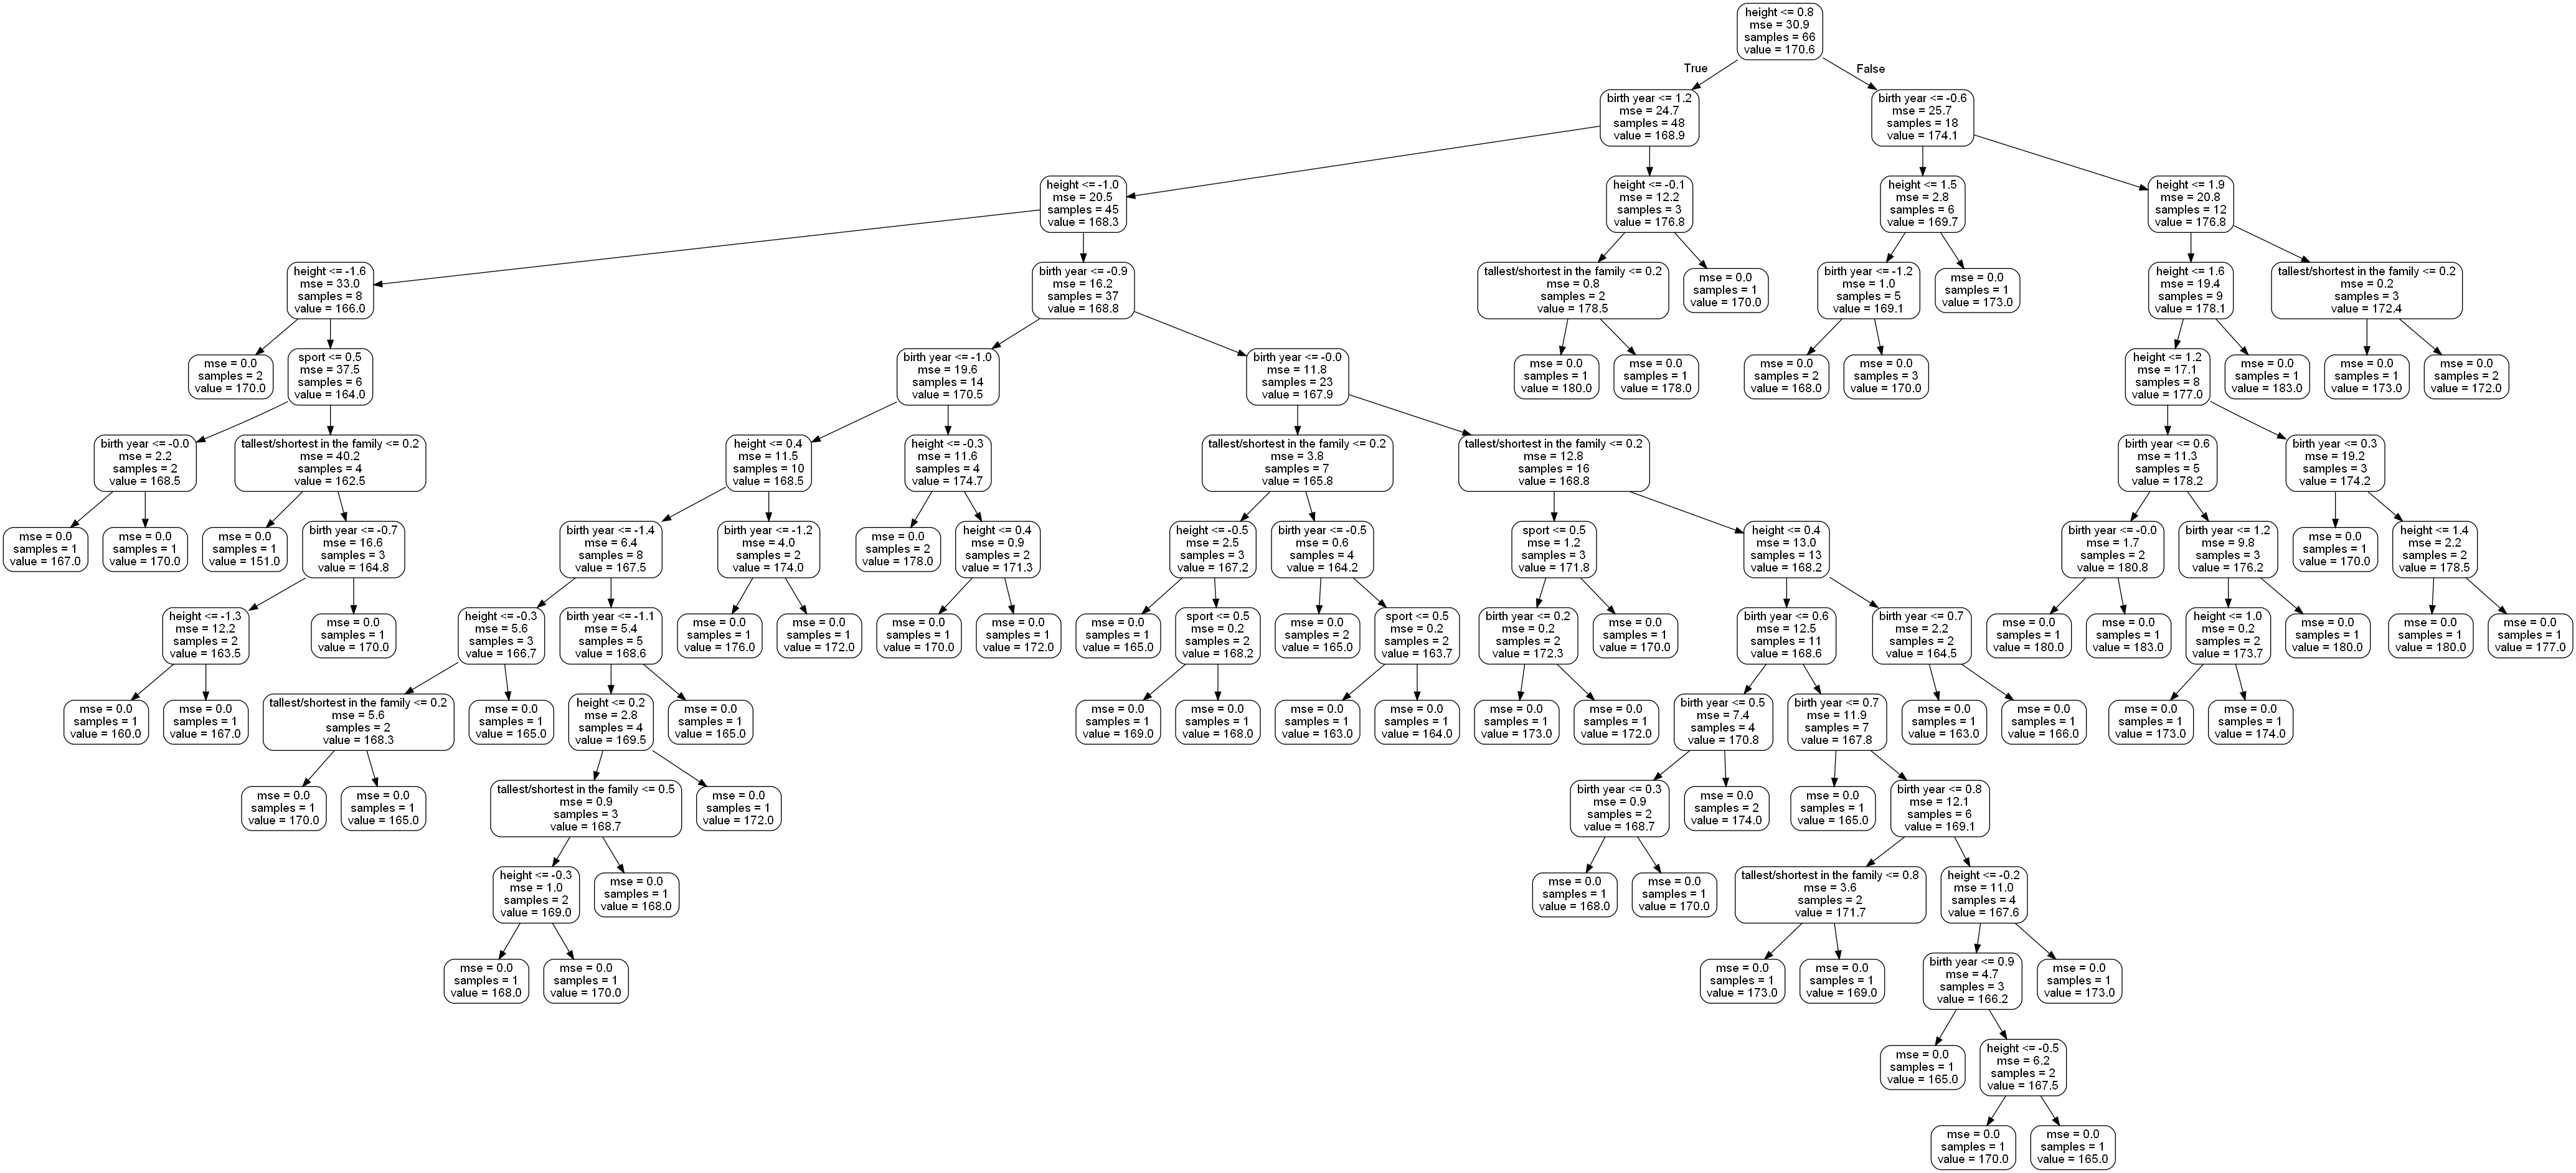

In [15]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[4]

# Pull out one tree from the forest
tree = rf.estimators_[4]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
!dot -Tpng tree.dot -o tree.png
Image.open(r"tree.png")

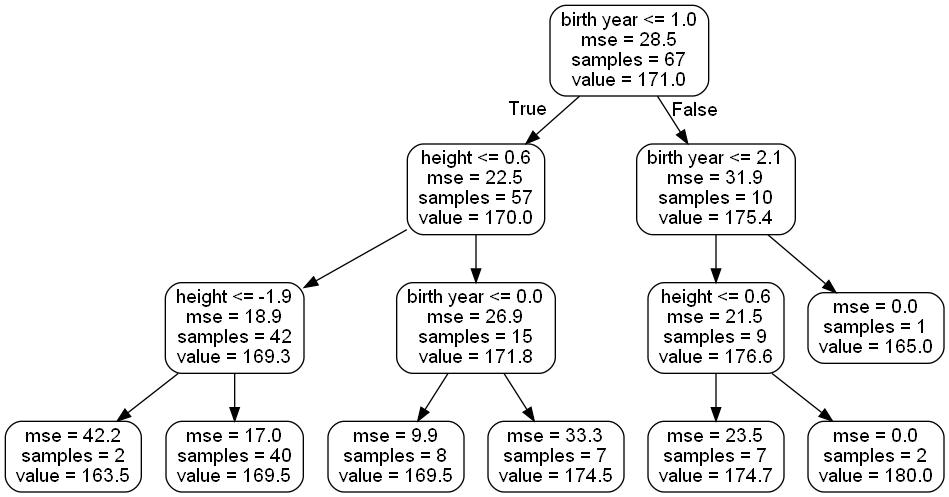

In [16]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
!dot -Tpng small_tree.dot -o small_tree.png
Image.open(r"small_tree.png")

In [17]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: birth year           Importance: 0.47
Variable: height               Importance: 0.37
Variable: tallest/shortest in the family Importance: 0.1
Variable: sport                Importance: 0.06


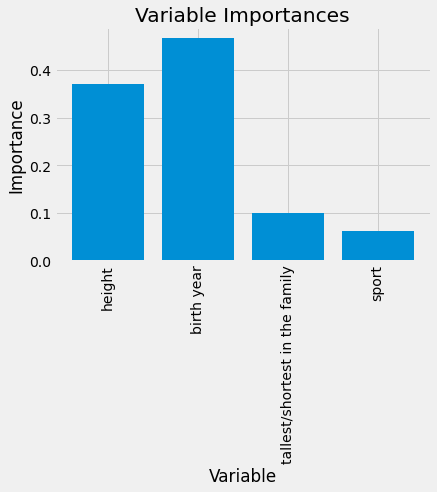

In [18]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');